# Channel flow with Navier-Stokes

The only difference between this final step and notebook 7 is that we are going to add a source term to the u-momentum equation, to mimic the effect of a pressure-driven channel flow. Here are our modified Navier–Stokes equations:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left( \frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right) +F$$
$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right)$$
$$
\frac{\partial^2 p}{\partial x^2} +\frac{\partial^2 p}{\partial y^2} =
\rho \left[\frac{\partial}{\partial t} \left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) - \left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right) \right]
$$

The initial condition is $u,v,p=0$ everywhere, and at the boundary conditions are:

$u,v,p$ are periodic on $x=0,2$

$u,v=0$ at $y=0,2$

$\frac{\partial p }{\partial y}=0$ at $y=0,2$

F=1 everywhere.

In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

One thing to note is that we have periodic boundary conditions throughout this grid, so we need to explicitly calculate the values at the leading and trailing edge of our u vector.

In [2]:
def build_up_b(rho, dt, dx, dy, u, v):
    b = numpy.zeros_like(u)
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dx) +
                                      (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dy)) -
                            ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dx))**2 -
                            2 * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dy) *
                                 (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dx))-
                            ((v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dy))**2))
    
    # Periodic BC Pressure @ x = 2
    b[-1, 1:-1] = (rho * (1 / dt * ((u[0, 1:-1] - u[-2, 1:-1]) / (2 * dx) +
                                    (v[-1, 2:] - v[-1, 0:-2]) / (2 * dy)) -
                          ((u[0, 1:-1] - u[-2, 1:-1]) / (2 * dx))**2 -
                          2 * ((u[-1, 2:] - u[-1, 0:-2]) / (2 * dy) *
                               (v[0, 1:-1] - v[-2, 1:-1]) / (2 * dx)) -
                          ((v[-1, 2:] - v[-1, 0:-2]) / (2 * dy))**2))

    # Periodic BC Pressure @ x = 0
    b[0, 1:-1] = (rho * (1 / dt * ((u[1, 1:-1] - u[-1, 1:-1]) / (2 * dx) +
                                   (v[0, 2:] - v[0, 0:-2]) / (2 * dy)) -
                         ((u[1, 1:-1] - u[-1, 1:-1]) / (2 * dx))**2 -
                         2 * ((u[0, 2:] - u[0, 0:-2]) / (2 * dy) *
                              (v[1, 1:-1] - v[-1, 1:-1]) / (2 * dx))-
                         ((v[0, 2:] - v[0, 0:-2]) / (2 * dy))**2))
    
    return b

We'll also define a Pressure Poisson iterative function, again like we did in Notebook 7. Once more, note that we have to include the periodic boundary conditions at the leading and trailing edge. We also have to specify the boundary conditions at the top and bottom of our grid.

In [3]:
def pressure_poisson_periodic(p, dx, dy):
    pn = numpy.empty_like(p)
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dy**2 +
                          (pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 1:-1])

        # Periodic BC Pressure @ x = 2
        p[-1, 1:-1] = (((pn[0, 1:-1] + pn[-2, 1:-1])* dy**2 +
                        (pn[-1, 2:] + pn[-1, 0:-2]) * dx**2) /
                       (2 * (dx**2 + dy**2)) -
                       dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[-1, 1:-1])

        # Periodic BC Pressure @ x = 0
        p[0, 1:-1] = (((pn[1, 1:-1] + pn[-1, 1:-1])* dy**2 +
                       (pn[0, 2:] + pn[0, 0:-2]) * dx**2) /
                      (2 * (dx**2 + dy**2)) -
                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[0, 1:-1])
        
        # Wall boundary conditions, pressure
        p[:, -1] =p[:, -2]  # dp/dy = 0 at y = 2
        p[:, 0] = p[:, 1]  # dp/dy = 0 at y = 0
    
    return p

Now we have our familiar list of variables and initial conditions to declare before we start.

In [4]:
##variable declarations
nx = 41
ny = 41
nt = 100
nit = 100
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y, indexing='ij')

##physical variables
rho = 1
nu = .1


F = 1
dt = .001

#initial conditions
u = numpy.zeros((nx, ny))
un = numpy.zeros((nx, ny))

v = numpy.zeros((nx, ny))
vn = numpy.zeros((nx, ny))

p = numpy.ones((nx, ny))
pn = numpy.ones((nx, ny))

b = numpy.zeros((nx, ny))

For the meat of our computation, we're going to reach back to a trick we used in Step 9 for Laplace's Equation. We're interested in what our grid will look like once we've reached a near-steady state. We can either specify a number of timesteps nt and increment it until we're satisfied with the results, or we can tell our code to run until the difference between two consecutive iterations is very small.

In [5]:
udiff = 1
stepcount = 0

while udiff > .001:
    un = u.copy()
    vn = v.copy()

    b = build_up_b(rho, dt, dx, dy, u, v)
    p = pressure_poisson_periodic(p, dx, dy)

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     dt / (2 * rho * dx) * 
                    (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * (dt / dx**2 * 
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]) +
                     dt / dy**2 * 
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2])) + 
                     F * dt)

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     dt / (2 * rho * dy) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * (dt / dx**2 *
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]) +
                     dt / dy**2 * 
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2])))

    # Periodic BC u @ x = 2     
    u[-1, 1:-1] = (un[-1, 1:-1] - un[-1, 1:-1] * dt / dx * 
                  (un[-1, 1:-1] - un[-2, 1:-1]) -
                   vn[-1, 1:-1] * dt / dy * 
                  (un[-1, 1:-1] - un[-1, 0:-2]) -
                   dt / (2 * rho * dx) *
                  (p[0, 1:-1] - p[-2, 1:-1]) + 
                   nu * (dt / dx**2 * 
                  (un[0, 1:-1] - 2 * un[-1, 1:-1] + un[-2, 1:-1]) +
                   dt / dy**2 * 
                  (un[-1, 2:] - 2 * un[-1, 1:-1] + un[-1, 0:-2])) + F * dt)

    # Periodic BC u @ x = 0
    u[0, 1:-1] = (un[0, 1:-1] - un[0, 1:-1] * dt / dx *
                 (un[0, 1:-1] - un[-1, 1:-1]) -
                  vn[0, 1:-1] * dt / dy * 
                 (un[0, 1:-1] - un[0, 0:-2]) - 
                  dt / (2 * rho * dx) * 
                 (p[1, 1:-1] - p[-1, 1:-1]) + 
                  nu * (dt / dx**2 * 
                 (un[1, 1:-1] - 2 * un[0, 1:-1] + un[-1, 1:-1]) +
                  dt / dy**2 *
                 (un[0, 2:] - 2 * un[0, 1:-1] + un[0, 0:-2])) + F * dt)

    # Periodic BC v @ x = 2
    v[-1, 1:-1] = (vn[-1, 1:-1] - un[-1, 1:-1] * dt / dx *
                  (vn[-1, 1:-1] - vn[-2, 1:-1]) - 
                   vn[-1, 1:-1] * dt / dy *
                  (vn[-1, 1:-1] - vn[-1, 0:-2]) -
                   dt / (2 * rho * dy) * 
                  (p[-1, 2:] - p[-1, 0:-2]) +
                   nu * (dt / dx**2 *
                  (vn[0, 1:-1] - 2 * vn[-1, 1:-1] + vn[-2, 1:-1]) +
                   dt / dy**2 *
                  (vn[-1, 2:] - 2 * vn[-1, 1:-1] + vn[-1, 0:-2])))

    # Periodic BC v @ x = 0
    v[0, 1:-1] = (vn[0, 1:-1] - un[0, 1:-1] * dt / dx *
                 (vn[0, 1:-1] - vn[-1, 1:-1]) -
                  vn[0, 1:-1] * dt / dy *
                 (vn[0, 1:-1] - vn[0, 0:-2]) -
                  dt / (2 * rho * dy) * 
                 (p[0, 2:] - p[0, 0:-2]) +
                  nu * (dt / dx**2 * 
                 (vn[1, 1:-1] - 2 * vn[0, 1:-1] + vn[-1, 1:-1]) +
                  dt / dy**2 * 
                 (vn[0, 2:] - 2 * vn[0, 1:-1] + vn[0, 0:-2])))


    # Wall BC: u,v = 0 @ y = 0,2
    u[:, 0] = 0
    u[:, -1] = 0
    v[:, 0] = 0
    v[:, -1]=0
    
    udiff = (numpy.sum(u) - numpy.sum(un)) / numpy.sum(u)
    stepcount += 1

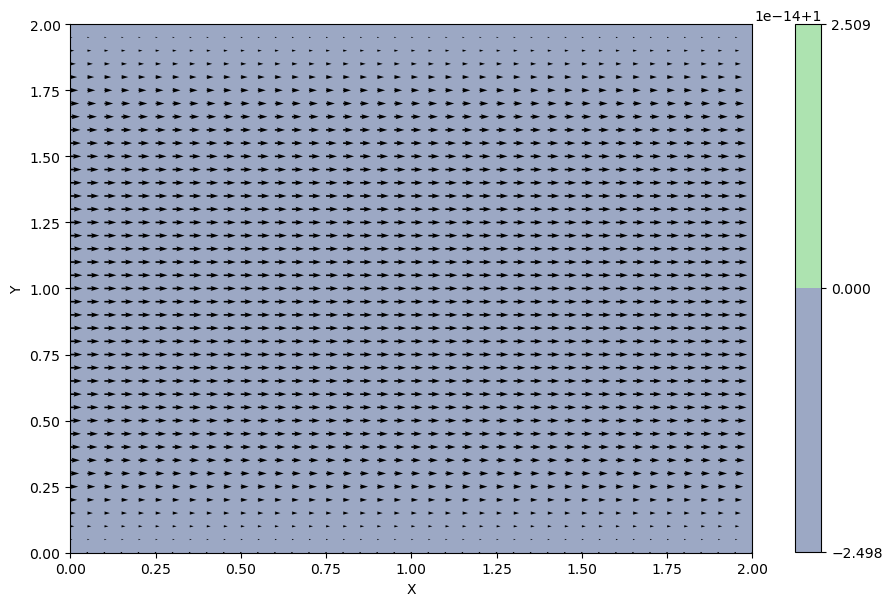

In [6]:
#NBVAL_IGNORE_OUTPUT
fig = pyplot.figure(figsize=(11,7), dpi=100)
# Plotting the pressure field as a contour.
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# We cannot plot contour lines as the pressure is a constant.
# Plotting velocity field.
pyplot.quiver(X, Y, u, v) 
pyplot.xlabel('X')
pyplot.ylabel('Y');

In [7]:
from devito import Grid

grid = Grid(shape=(nx, ny), extent=(2., 2.))
x, y = grid.dimensions
t = grid.stepping_dim

u = numpy.zeros((nx, ny))
v = numpy.zeros((nx, ny))
p = numpy.zeros((nx, ny)) 

The initial condition is $u,v,p=0$ everywhere, and at the boundary conditions are:

$u,v,p$ are periodic on $x=0,2$

$u,v=0$ at $y=0,2$

$\frac{\partial p }{\partial y}=0$ at $y=0,2$

F=1 everywhere.

In [8]:
from devito import TimeFunction, first_derivative, Function, \
Constant, Eq, solve, left, Operator, configuration

# Build Required Functions and derivatives:
# --------------------------------------
# |Variable | Required Derivatives     |
# --------------------------------------
# |   u     | dt, dx, dy, dx**2, dy**2 |
# |   v     | dt, dx, dy, dx**2, dy**2 |
# |   p     |     dx, dy, dx**2, dy**2 |
# |   pn    |     dx, dy, dx**2, dy**2 |
# --------------------------------------
u = TimeFunction(name='u', grid=grid, space_order=2)
v = TimeFunction(name='v', grid=grid, space_order=2)
p  = Function(name='p',  grid=grid, space_order=2)
pn = Function(name='pn', grid=grid, space_order=2)

eq_u =Eq(u.dt + u*u.dxc + v*u.dyc, -1/rho * p.dxc + nu*(u.laplace)+F*dt,  subdomain=grid.interior)
eq_v =Eq(v.dt + u*v.dxc + v*v.dyc, -1/rho * p.dyc + nu*(v.laplace),  subdomain=grid.interior)
#eq_pn=Eq(pn.laplace,rho*(1./dt*(u_dx+v_dy)-(u_dx*u_dx)+2*(u_dy*v_dx)+(v_dy*v_dy)),  subdomain=grid.interior)
eq_pn=Eq(pn.laplace,rho*(1./dt*(u.dxc+v.dyc)-(u.dxc*u.dxc)+2*(u.dyc*v.dxc)+(v.dyc*v.dyc)),  subdomain=grid.interior)

# NOTE: Pressure has no time dependence so we solve for the other pressure buffer.
stencil_u =solve(eq_u , u.forward)
stencil_v =solve(eq_v , v.forward)
stencil_pn=solve(eq_pn, pn)
 
update_u =Eq(u.forward, stencil_u)
update_v =Eq(v.forward, stencil_v)
update_pn=Eq(p       , stencil_pn) # calc p from pn.

# Boundary Conds. 
# Note that Devito does not have a way to build periodic boundary conditions yet.
# As such we need to code them by hand.
#    u,v,p are periodic on $x=0,2$
bc_u  = [Eq(u[t+1, 0   , y   ], u[t+1, nx-2, y   ])]  
bc_u  += [Eq(u[t+1, 1   , y   ], u[t+1, nx-1, y   ])]  

bc_v  = [Eq(v[t+1, 0   , y   ], v[t, nx-2, y   ])]  
bc_v  += [Eq(v[t+1, 1   , y   ], v[t+1, nx-1, y   ])]  

bc_pn = [Eq(pn[1       , y   ], pn[nx-1, y   ])]
bc_pn += [Eq(pn[0       , y   ], pn[nx-2, y   ])]

bc_p  = [Eq(p [1       , y   ], p [nx-1, y   ])]
bc_p  += [Eq(p [0       , y   ], p [nx-2, y   ])]

bc_p  += [Eq(p[x    ,ny-1],p[x    ,ny-2])]     # ∂𝑝/∂𝑦=0 at 𝑦=0,2
bc_p  += [Eq(p[x    ,0],p[x       ,1])] 

bc_pn += [Eq(p[x    ,ny-1],p[x    ,ny-2])]     # ∂𝑝/∂𝑦=0 at 𝑦=0,2
bc_pn += [Eq(p[x    ,0],p[x       ,1])]      


# Wall boundary Conditions
bc_u  += [Eq(u[t+1, x   , 0   ], 0)]  
bc_u  += [Eq(u[t+1, x   , ny-1   ], 0)]  
bc_v  += [Eq(v[t+1, x   , 0   ], 0)]  
bc_v  += [Eq(v[t+1, x   , ny-1   ], 0)]  

bc=bc_u+bc_v

optime=Operator([update_u, update_v]+bc+bc_p+bc_pn)
oppres=Operator([update_pn]+bc+bc_p+bc_pn)

In [9]:
import numpy as np
from examples.cfd import plot_field

# Silence non-essential outputs from the solver.
configuration['log-level'] = 'ERROR'

# Initialise velocities and pressures.
u.data[:]  = 0.
v.data[:]  = 0.
p.data[:]  = 0.
pn.data[:] = 0.
nt=700
dt=0.001
# This is the time loop.
for step in range(nt):
    l1norm_target = 5.e-4
    l1norm = 1
    counter = 0
    # Loop over pseudo time to solve time independent pressures.
    while l1norm > l1norm_target:
            # Determine buffer order
        if counter % 2 == 0:
            _p = p
            _pn = pn
        else:
            _p = pn
            _pn = p

        # Apply pressure operator
        oppres(p=_p, pn=_pn,time=1)
        # Note: On the first pass the below will throw a runtime error.
        #   This is because in the initial pressure solution, the sum of
        #   all pressures = 0.
        l1norm = (np.sum(np.abs(_p.data[:]) - np.abs(_pn.data[:])) /
                      (np.sum(np.abs(_p.data[:]))+0.000001))
        
        counter += 1
    optime(time=1, dt=dt)

The below plot is a good approximation of the one above, however it is clear that the periodic boundary conditions at the left and right side are not behaving as they should. Notably, the pressure solution is non-negligible and there is a noticable divergence in the velocity field as it approaches the right hand side.

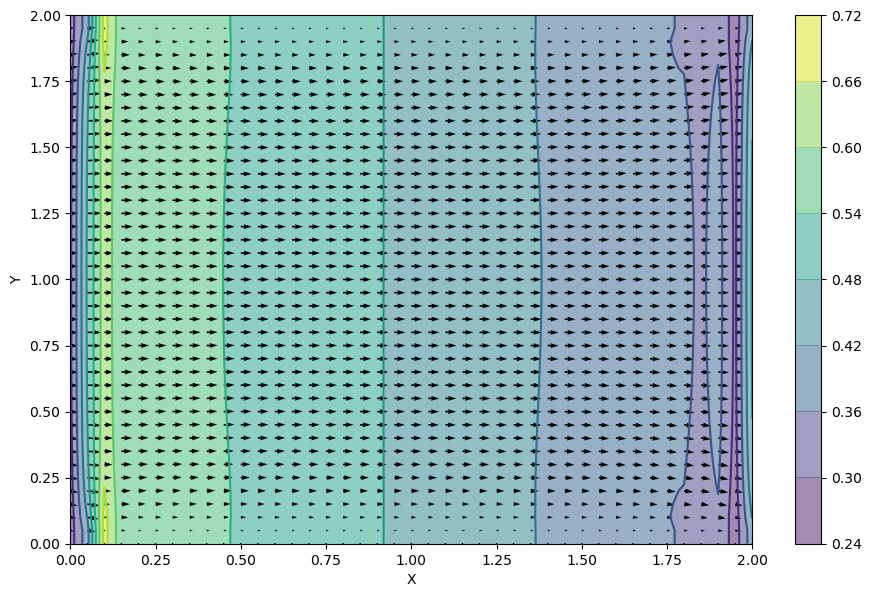

In [10]:
#NBVAL_IGNORE_OUTPUT
fig = pyplot.figure(figsize=(11,7), dpi=100)
# Plotting the pressure field as a contour.
pyplot.contourf(X, Y, p.data, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# Plotting the pressure field outlines.
pyplot.contour(X, Y, p.data, cmap=cm.viridis)  
# Plotting velocity field.
pyplot.quiver(X[:,:], Y[:,:], u.data[0,:,:], v.data[0,:,:]) 
pyplot.xlabel('X')
pyplot.ylabel('Y');